In [1]:
import sys
import utils_

import cv2
import numpy as np

from skimage import io

### Obtain transformation matrix

In [84]:
# Obtaining transformation matrix from first frame
image_name = '../images/frame_0.jpg'
image = io.imread(image_name)
# save_name = '.'.join(image_name.split('.')[:-1]) + '_warped.jpg'
r_img, matrix = utils_.rectify_image(image_name, 2, algorithm='independent')
# io.imsave(save_name, r_img)

Using first frame with no people in the field of vision, to get the transformation matrix which will be used later for **Perspective Transformation** of bounding boxes to avoid false positives (Here the transfomation is done to get the birds eye view of the image)

### Object Detection

In [3]:
#Load YOLO
net = cv2.dnn.readNet("yolov3.weights","yolov3.cfg")
classes = []
with open("coco.names","r") as f:
    classes = [line.strip() for line in f.readlines()]
    
layer_names = net.getLayerNames()
outputlayers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

colors = np.random.uniform(0,255,size=(len(classes),3))

In [4]:

def get_object_detections(image):
    
    img = cv2.imread(image)
    # img = cv2.resize(img,None,fx=0.4,fy=0.3)
    height,width,channels = img.shape


    #detecting objects
    blob = cv2.dnn.blobFromImage(img,.005,(416,416),(0,0,0),True,crop=False)


    # for b in blob:
    #     for n,img_blob in enumerate(b):
    #         cv2.imshow(str(n),img_blob)

    net.setInput(blob)
    outs = net.forward(outputlayers)
    #print(outs[1])


    #Showing info on screen/ get confidence score of algorithm in detecting an object in blob
    class_ids=[]
    confidences=[]
    boxes=[]

    objects_coords = {}

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.0:
                #onject detected
                center_x= int(detection[0]*width)
                center_y= int(detection[1]*height)
                w = int(detection[2]*width)
                h = int(detection[3]*height)

    #             cv2.circle(img,(center_x,center_y),10,(0,255,0),8)
                #rectangle co-ordinaters
                x=int(center_x - w/2)
                y=int(center_y - h/2)
    #             cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

                boxes.append([x,y,w,h])
                confidences.append(float(confidence)) 
                class_ids.append(class_id) 

    indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.1,0.9)

    for i in range(len(boxes)):
        if i in indexes:
            x,y,w,h = boxes[i]
            label = str(classes[class_ids[i]])
    #         if label == 'diningtable':

            color = colors[i]
            if label not in objects_coords.keys():
                objects_coords[label] = [[x,y,w,h]]
            else:
                objects_coords[label].append([x,y,w,h])
    #         if label=='chair':
            cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
            cv2.putText(img,label,(x,y+30),cv2.FONT_HERSHEY_PLAIN,1,(0,0,0),2)
    #             break
    # cv2.imshow("Image",img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    return img, objects_coords

def group_tables(object_coords):
    """
    Returns the grouped coordinates as part of a table
    """
    
    table_nums = {}
    num = 0
    for ch in objects_coords['chair']:
        x,y,w,h = ch
        ch_poly = Polygon([(x,y), (x+w,y), (x+w,y+h), (x,y+h)])
        for i, tbl in enumerate(objects_coords['diningtable']):
            a,b,c,d = tbl
            tbl_coords = [(a,b), (a+c,b), (a+c,b+d), (a,b+d)]
            if not ch_poly.intersects(Polygon(tbl_coords)):
                continue

            tn = str(tbl_coords)
            if tn not in table_nums.keys():
                table_nums[tn] = [[x,y,w,h]]
                break
            else:
                table_nums[tn].append([x,y,w,h])
                break

        if i+1==len(objects_coords['diningtable']):
            num += 1
            tn = 'table_'+str(num)
            if tn not in table_nums.keys():
                table_nums[tn] = [[x,y,w,h]]
            else:
                table_nums[tn].append([x,y,w,h])

    old_keys = [k for k in table_nums.keys() if 'table_' not in k]
    for k in old_keys:
        num += 1
        tn = 'table_'+str(num)
        table_nums[tn] = table_nums.pop(k)

    return table_nums


from shapely.geometry import MultiPolygon, Polygon
def detect_polygons(detections):

    polygons_dict = {}
    for k,v in detections.items():
        
        polygons = [Polygon([(sx,sy), (sx+sw,sy), (sx+sw,sy+sh), (sx,sy+sh)]) for sx,sy,sw,sh in v]
        polygons = MultiPolygon(polygons)
        polygons = polygons.buffer(20).buffer(-20)
        polygons_dict[k] = polygons
        
    return polygons_dict

# Read and Write Pickle files
import pickle
def write_pickle(filename, obj):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_pickle(filename):
    with (open(filename, 'rb')) as handle:
        obj = pickle.load(handle)
    return obj

# Read and Wirte JSON
import json
def write_json(filename, obj):
    with open(filename, 'w') as fp:
        json.dump(obj, fp)
        
def read_json(filename):
    with open(filename) as f:
        obj = json.load(f)
    return obj


### People Counter

In [5]:

from PIL import Image
from glob import glob
from collections import Counter

from shapely.geometry import Point, Polygon, box
from shapely.ops import transform, cascaded_union
from shapely.affinity import scale

In [6]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


**Note:** For now, I'm not labelling in the image which table is which (in the sense, the location of table in image)

In [162]:
# Counter for keeping track of number of people per table

table_polygons = read_pickle('polygons.pickle')
tk = table_polygons.keys()
# people_counter = dict(zip(tk, [[]]*len(tk)))
people_counter = {}
for k in tk:
    people_counter[k] = []

    
for img in sorted(glob("../images/frame_*.jpg"), key=numericalSort)[40:41]:
    counter = dict(zip(tk, [0]*len(tk)))
    
    print(img) 
    i = cv2.imread(img)
    h,w,_ = i.shape
    io.imsave('c.jpg', cv2.warpPerspective(i, matrix, (h, w)))
    
#     tr_img, _ = utils_.rectify_image(img, 2, algorithm='independent')
#     io.imsave('a.jpg', tr_img)
    tr_img = Image.open('c.jpg').convert('RGBA')
    
    image, objects_coords = get_object_detections(img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#     display(Image.fromarray(image))

#     table_nums = group_tables(objects_coords)
#     table_polygons = detect_polygons(table_nums)

    # Written polygon areas from first blank frame
    # write_pickle('polygons.pickle', table_polygons)
    
    _, objects_coords_person = get_object_detections(img)
    if 'person' not in objects_coords_person.keys():
        list(map(lambda kv: people_counter[kv[0]].append(kv[1]), zip(people_counter, list(counter.values()))))
        continue
    
    for k,v in table_polygons.items():
        
#         if type(v) == Polygon:
#             tbl_polys = [v]
#         else:
#             tbl_polys=[]
#             for tbl_poly in v:
#                 rot_poly = cv2.perspectiveTransform(
#                     np.array(tbl_poly.exterior.coords[:]).reshape(-1, 1, 2).astype(np.float32), matrix)
#                 tbl_polys.append(Polygon([tuple(tp[0]) for tp in rot_poly]))

#         sx,sy,tx,ty = tbl_poly.bounds
        
        sx,sy,tx,ty = v.bounds
        quad_pts = np.float32([[sx,sy], [tx,sy], [tx,ty], [sx,ty]])
        transformed_pts = cv2.perspectiveTransform(quad_pts.reshape(-1, 1, 2).astype(np.float32), matrix)
        transformed_pts_flattened = [tuple(tp[0]) for tp in transformed_pts]

        poly = Polygon(transformed_pts_flattened)
        
        for i, (px,py,pw,ph) in enumerate(objects_coords_person['person']):
            person_pts = np.float32([[px,py], [px+pw,py], [px+pw,py+ph], [px,py+ph]])
            transformed_pts_person = cv2.perspectiveTransform(person_pts.reshape(-1, 1, 2).astype(np.float32), 
                                                              matrix)
            transformed_pts_flattened_person = [tuple(tp[0]) for tp in transformed_pts_person]
            poly_person = Polygon(transformed_pts_flattened_person)
            poly_person = scale(poly_person, xfact=1.0, yfact=1.0, zfact=1.0, origin='center')
            
            
            x = list(poly_person.exterior.coords.xy[0])
            y = list(poly_person.exterior.coords.xy[1])
            draw = ImageDraw.Draw(tr_img)
            draw.line(list(zip(x,y)), fill="red", width=9)

#             for poly in tbl_polys:
            poly = scale(poly, xfact=1.0, yfact=-1.0, zfact=1.0, origin='center')
            if (poly.intersects(poly_person)):
                if (poly_person.intersection(poly).area / poly.area * 100) >= 1:
                    counter[k] += 1
                    
    list(map(lambda kv: people_counter[kv[0]].append(kv[1]), zip(people_counter, list(counter.values()))))
    

../images/frame_40.jpg


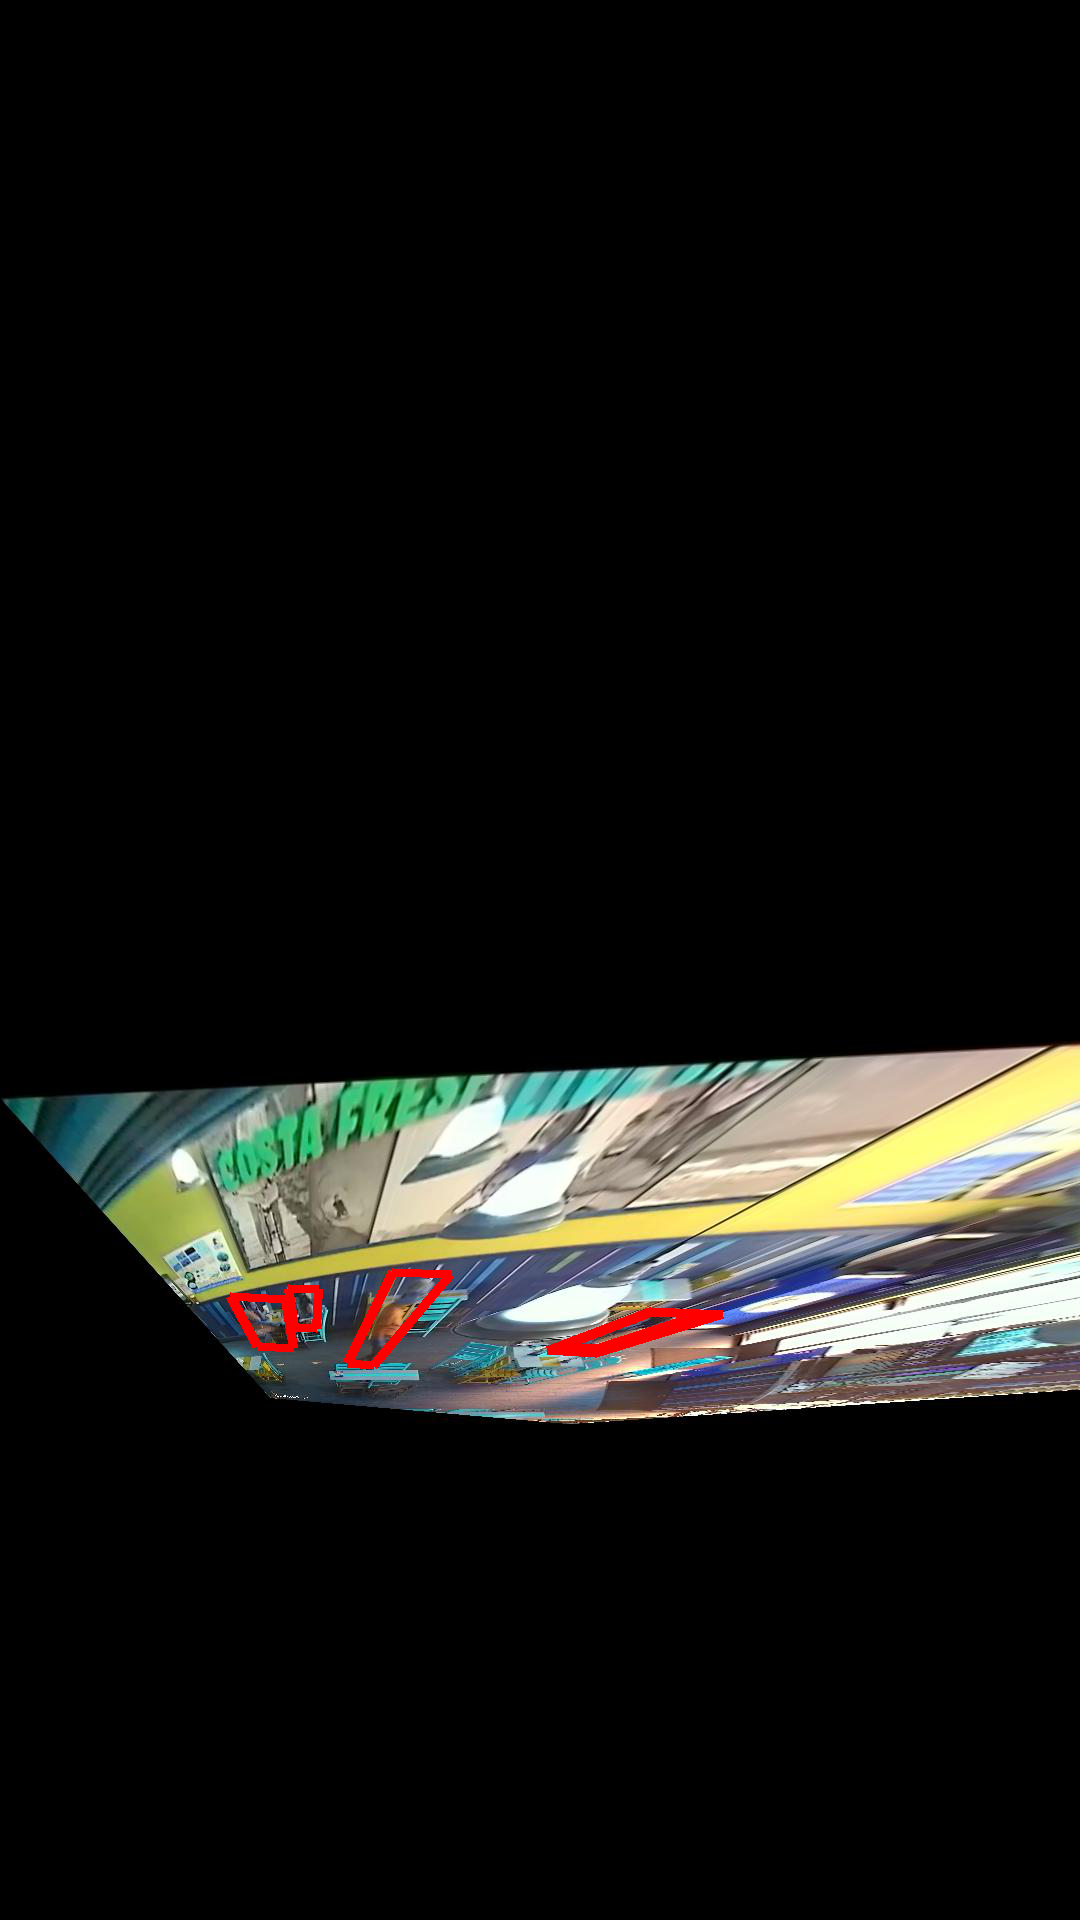

In [163]:
from PIL import ImageDraw
tr_img

### Plot

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
%matplotlib inline


In [32]:
from datetime import datetime, timedelta
num_images = len(glob('../images/*'))
start_time = datetime(2020, 6, 29, 13, 0, 0) + timedelta(0, 60)
x = [start_time + timedelta(0, 60) for i in range(num_images)]
date_time = [d.strftime("%m/%d/%Y, %H:%M:%S") for d in x]

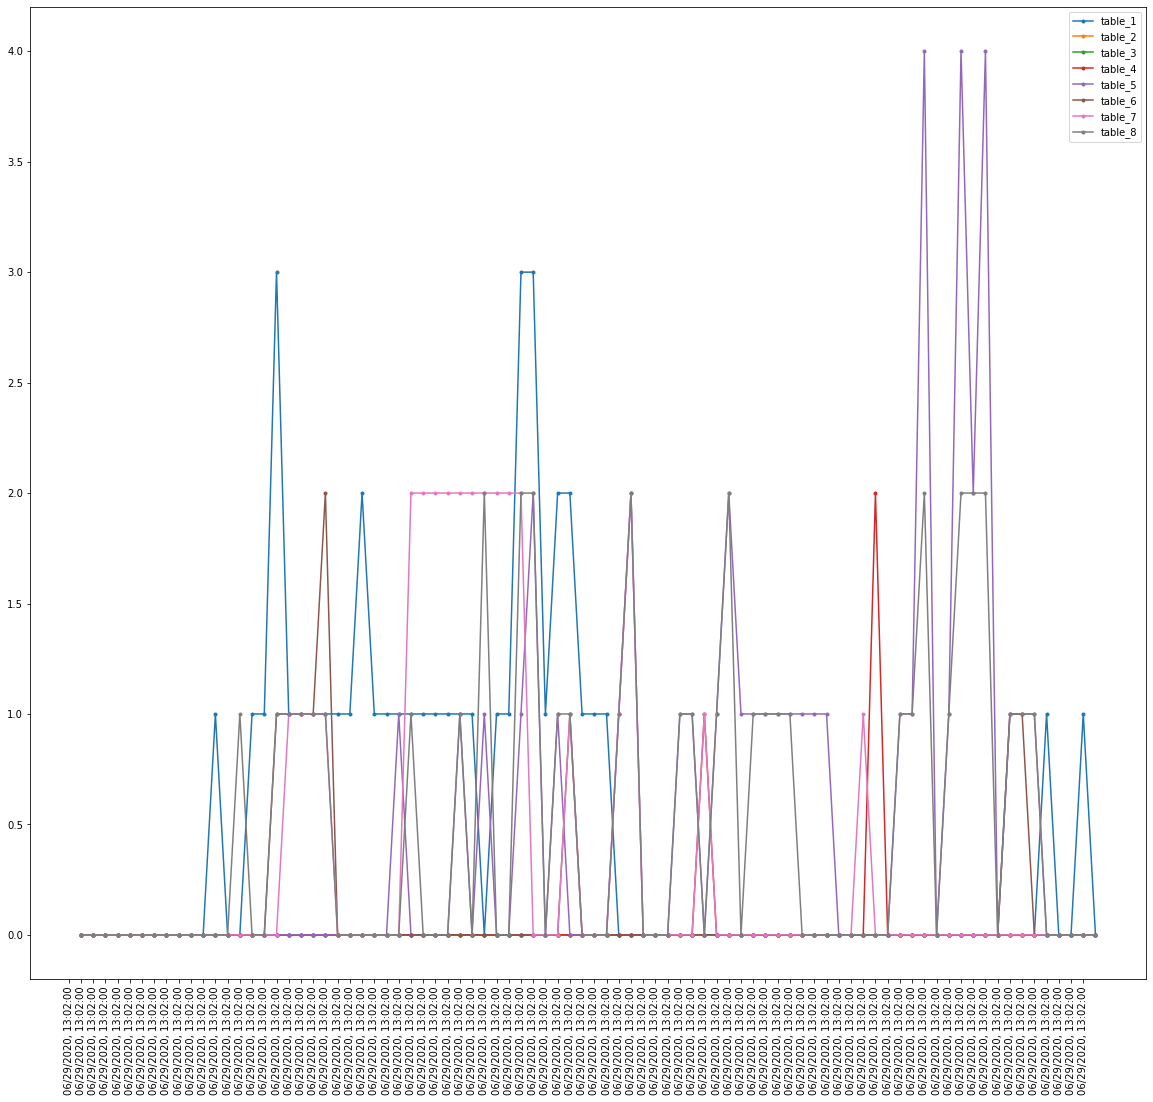

In [33]:

fig = plt.figure(figsize=(20,20)) 
fig.subplots_adjust(top = 0.8) 
ax1 = fig.add_subplot(111) 
plt.xticks(np.arange(num_images), date_time, rotation=90)

for k, v in people_counter.items():
    ax1.plot(range(1, len(v) + 1), v, '.-', label=k)
    # NOTE: changed `range(1, 4)` to mach actual values count
plt.legend()  # To draw legend
plt.show()